# Genetic attribution overview

In this notebook we overview the [Genetic Engineering Attribution competition in Driven Data](https://www.drivendata.org/competitions/63/genetic-engineering-attribution/).   

In [59]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import requests
from tqdm import tqdm
from collections import OrderedDict, defaultdict, Counter
import seaborn as sns

CPU times: user 39 µs, sys: 1 µs, total: 40 µs
Wall time: 46 µs


## Loading data

In [2]:
%%time
#parent_dir = "/content/genetic_engineering_attribution"
parent_dir = "/home/rio/data_sets/genetic_engineering_attribution"

### train/val/test directories
train_dir = os.path.join(parent_dir,"train") 
val_dir = os.path.join(parent_dir,"val")
test_dir = os.path.join(parent_dir,"test")

### Paths to csvs
train_path = os.path.join(train_dir,"train.csv")
val_path = os.path.join(val_dir,"val.csv")
test_path = os.path.join(test_dir,"test.csv")

### Dataframes
df_train = pd.read_csv(train_path,index_col=0)
df_val = pd.read_csv(val_path,index_col=0)
df_test = pd.read_csv(test_path,index_col=0)

### Printing shapes:
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (50413, 43)
Shape of df_val: (12604, 43)
Shape of df_test: (18816, 43)
CPU times: user 2.05 s, sys: 180 ms, total: 2.23 s
Wall time: 2.22 s


In [3]:
df_train.head()

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
4350,SMVSS,I7FXTVDP,GACGGATCGGGAGATCTCCCGATCCCCTATGGTGCACTCTCAGTAC...,7723,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10470,6MC5M,I7FXTVDP,GCTAGAGCCGTGAACGACAGGGCGAACGCCAGCCCGCCGACGGCGA...,10550,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
30997,BHOUO,P3Q11IAK,GGCTTTGTTAGCAGCCGGATCCTTATCAGTCTGCGGCAGGATTGGC...,1085,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29915,EI1J7,I7FXTVDP,GACGGATCGGGAGATCTCCCGATCCCCTATGGTGCACTCTCAGTAC...,9216,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19843,NVS4Z,AMV4U0A0,TATACGACTCACTATAGGGCGAATTGGGCCCTCTAGATGCATGCTC...,975,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Histogram of sequence lengths

We wish to generate data sets of equal-length sequences. To do that, we must first have an idea of the length distribution of DNA sequences. Note that at the lowest length extreme (q=0.001), the length is 165. We can, therefore, generate datasets with DNA snipetts of length 128.

In [4]:
min_ = np.quantile(df_train.seq_length.values,0.001)
min_

165.41199999999998

In [5]:
max_ = np.quantile(df_train.seq_length.values,0.999)

In [6]:
max_

22731.936000000074

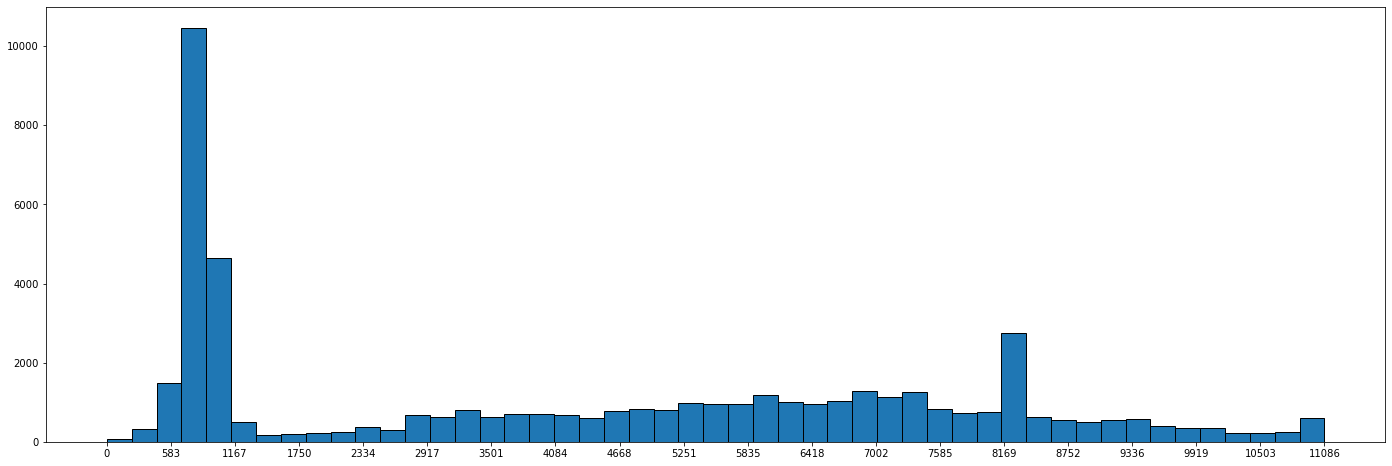

In [7]:
fig, ax = plt.subplots(figsize=(24,8))
max_ = np.quantile(df_train.seq_length.values,0.95)
n_bins=100
bins = np.linspace(0,max_,50)
xticks = np.linspace(0,max_,20)
ax.hist(df_train.seq_length.values,bins=bins,histtype="bar",edgecolor='black')
ax.set_xticks(xticks)

In [8]:
df_train.seq_length.describe()

count    50413.000000
mean      4846.758773
std       3897.863677
min         20.000000
25%        910.000000
50%       4746.000000
75%       7511.000000
max      60099.000000
Name: seq_length, dtype: float64

## Bar plot of lab counts

In [9]:
df_train.lab_id.value_counts()

I7FXTVDP    6651
RKJHZGDQ    2219
GTVTUGVY    2140
A18S09P2     846
Q2K8NHZY     785
            ... 
3D9CMQ4V       2
W2DYAZID       2
WB78G3XF       1
0L3Y6ZB2       1
ON9AXMKF       1
Name: lab_id, Length: 1314, dtype: int64

/home/rio/anaconda3/envs/genetic_attribution/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lab_id', ylabel='count'>

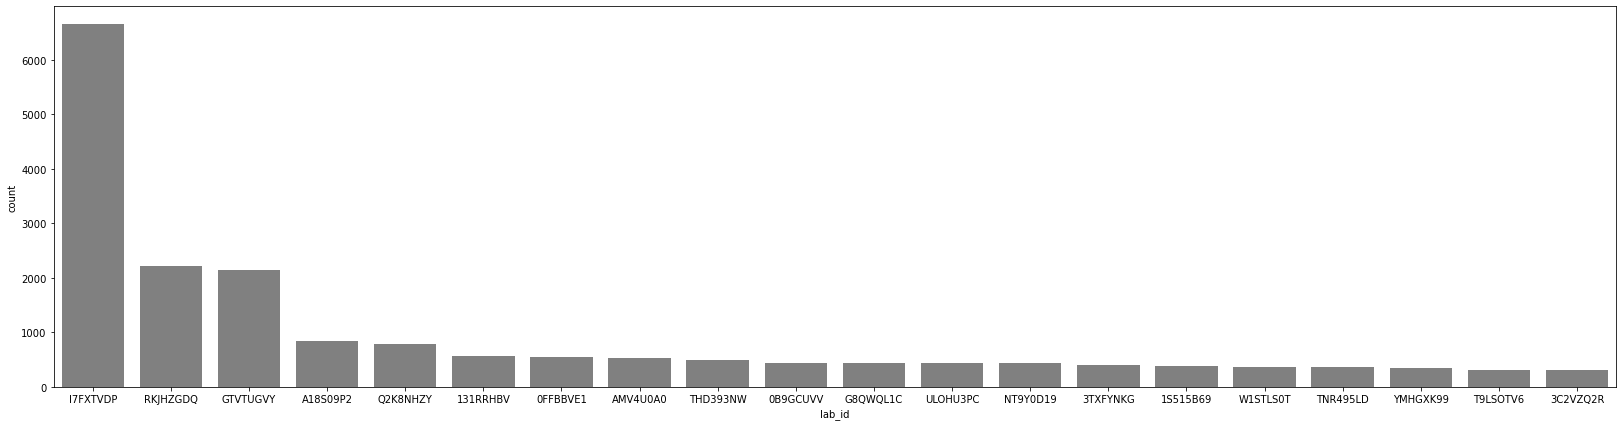

In [19]:
plt.figure(figsize=(28,7))
sns.countplot(df_train['lab_id'], color='gray',order=df_train.lab_id.value_counts().iloc[:20].index)

We should note that that the most frequent `lab_id` counts 6651 occurrences. Given that in the training set we have 50413 occurrences, a performance of ~ 13.2% should be our lowest reference score.

In [50]:
%%time
dna_snips = ["A","T", "G", "C"]
df_s_features = generate_string_features(snipps, dna_snips, stride=1)

100%|██████████| 1000000/1000000 [01:55<00:00, 8675.03it/s]


CPU times: user 1min 55s, sys: 399 ms, total: 1min 56s
Wall time: 1min 55s


In [51]:
df_s_features

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish,A,T,G,C
24009,GBDQW,RBLPDV4R,CAACGTCGGGGCGGCAGGCCCTGCCATAGCCTCAGGTTACTCATAT...,128,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0110000000000001000000000101000001000010001010...,0000010000000000000001000010000100001100100101...,0000100111101100110000100000100000110000000000...,1001001000010010001110011000011010000001010000...
45718,YBAVP,ULVU086L,GGCGAGATCCGGAAGCGGCCTCTGATCGAGACAAACGGCGAAACCG...,128,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0000101000001100000000001000101011100000111000...,0000000100000000000010100100000000000000000000...,1101010000110010110000010001010000001101000001...,0010000011000001001101000010000100010010000110...
11166,R3F4C,I7FXTVDP,TTGAACCATTAGGAGTAGCACCCACCAAGGCAAAGAGAAGAGTGGT...,128,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0001100100100100100100010011000111010110100000...,1100000011000001000000000000000000000000001001...,0010000000011010010000000000110000101001010110...,0000011000000000001011101100001000000000000000...
12923,7PYM7,0PJ91ZT6,GAGGGAAGATTCTGCACGTCCCTTCCAGGCGGCCTCCCCGTCACCA...,128,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0100011010000001000000000010000000000000001001...,0000000001101000001000110000000000100000100000...,1011100100000100010000000001101100000001000000...,0000000000010010100111001100010011011110010110...
55037,6DFDA,0NP55E93,ACCACGCTGATGAGCTTTACCGCAGCTGCCTCGCGCGTTTCGGTGA...,128,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1001000001001000001000010000000000000000000001...,0000000100100001110000000010001000000111000100...,0000010010010100000001001001000010101000011010...,0110101000000010000110100100110101010000100000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61495,G0XRR,1IXFZ3HO,TATGGTGCACTCTCAGTACAATCTGCTCTGATGCCGCATAGTTAAG...,128,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0100000010000010010110000000001000000101000110...,1010010000101000100001010010100100000010011000...,0001101000000001000000001000010010010000100001...,0000000101010100001000100101000001101000000000...
17576,0EHTU,I1RQMFZC,GATCTTCAATTCCGGCGCCTAGAGAAGGAGTGAGGGCTGGATAAAG...,128,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0100000110000000000010101100100010000000101110...,0010110001100000000100000000001000000100010000...,1000000000000110100001010011010101110011000001...,0001001000011001011000000000000000001000000000...
50359,9U8T5,3TXFYNKG,GGGGGGTTCGTGCACACAGCCCAGCTTGGAGCGAACGACCTACACC...,128,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0000000000000101010000100000010001100100010100...,0000001100100000000000000110000000000000100000...,1111110001010000001000010001101010001000000000...,0000000010001010100111001000000100010011001011...
60520,OSIJ4,EOQAQ9X1,GTGGCGTGGTGTGCACTGTGTTTGCTGACGCAACCCCCACTGGTTG...,128,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0000000000000010000000000001000110000010000000...,0100001001010000101011100100000000000000100110...,1011010110101000010100010010010000000000011001...,0000100000000101000000001000101001111101000000...


In [52]:
df_s_features.A

24009    0110000000000001000000000101000001000010001010...
45718    0000101000001100000000001000101011100000111000...
11166    0001100100100100100100010011000111010110100000...
12923    0100011010000001000000000010000000000000001001...
55037    1001000001001000001000010000000000000000000001...
                               ...                        
61495    0100000010000010010110000000001000000101000110...
17576    0100000110000000000010101100100010000000101110...
50359    0000000000000101010000100000010001100100010100...
60520    0000000000000010000000000001000110000010000000...
3932     0001100000000000000000001000000010011110000011...
Name: A, Length: 1000000, dtype: object

In [56]:
np.array(list("01100000")).astype(int).sum()

2

## Extracting features from training data

We now write a function that counts the occurences of a string pattern through the whole data set

In [67]:
def count_patterns(sequence, pattern_len=8,stride=1):
    pattern_dict = defaultdict(lambda: 0)
    start_ixs = range(0,len(sequence)-pattern_len,stride)
    for ix in start_ixs:
        pattern_dict[sequence[ix:ix+pattern_len]] += 1 
    return pattern_dict

def count_df_patterns(df, pattern_len, stride=1):
    pattern_dict = Counter(defaultdict(lambda: 0))
    sequences = df.sequence.values
    pbar = tqdm(sequences)
    for seq in pbar:
        seq_count = Counter(count_patterns(seq, pattern_len,stride))
        pattern_dict += seq_count
    return pattern_dict

In [ ]:
pattern_len = 8
stride = 1
payttern_counts_8 = count_df_patterns(snipps, pattern_len, stride)

In [60]:
Counter(defaultdict(lambda: 0))

Counter()

In [64]:
a = defaultdict(lambda:0)
b = defaultdict(lambda:0)
c = defaultdict(lambda:0)

In [65]:
a["a"] = 2
b["a"] = 1
b["b"] = 3
c["c"] = 4
c["b"] = 10
c["d"] += 1

In [66]:
Counter(a) + Counter(b) + Counter(c)

Counter({'a': 3, 'b': 13, 'c': 4, 'd': 1})

In [57]:
import re

string = 'aaaa'
pattern = "aaa"

n =re.findall(pattern, string)
n


['aaa']

## Counting s snippets 

### Testing snippets with a single lab

In [245]:
np.random.seed(8469)
l = 100
min_seq_length=None
df_lab = df_train[df_train.lab_id=="00Q4V31T"]
size=None
p=None
#snip, wind, length, sampled_ixs = generate_snippets(df_lab, l, min_seq_length, size, replace, p)
snipps = generate_snippets(df_lab, l, min_seq_length, size, replace, p)

In [246]:
snipps

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
5085,8F6QY,00Q4V31T,TCGGCACGCCGGGACGTGTTCTGGATCATATCGAAAAAGGCACGCT...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2048,1FJ1X,00Q4V31T,CCGGCCTTCCGTGACGCCCTGACTCGCCTGAACAAAGGTCAAATGA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4200,3LP7Y,00Q4V31T,CGATCATCGTCGCGCTCCAGCGAAAGCGGTCCTCGCCGAAAATGAC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10488,OENP7,00Q4V31T,GTCTGTAAGCGGATGCCGGGAGCAGACAAGCCCGTCAGGGCGCGTC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2701,1LCI1,00Q4V31T,GTACCGTCTTCATGGGAGAAAATAATACTGTTGATGGGTGTCTGGT...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2699,OB8FG,00Q4V31T,GTTGTTTGTCGGTGAACGCTCTCCTGAGTAGGACAAATCCGCCGGG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2004,ZPRGH,00Q4V31T,CGGTCACAGCTTGTCTGTAAGCGGATGCCGGGAGCAGACAAGCCCG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10489,F0VAK,00Q4V31T,CCCAGTCACGACGTTGTAAAACGACGGCCAGTGAATTCTAATACGA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,CGATCGGAGGACCGAAGGAGCTAACCGCTTTTTTGCACAACATGGG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2699,OB8FG,00Q4V31T,CGCAGCGGTCGGGCTGAACGGGGGGTTCGTGCACACAGCCCAGCTT...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [247]:
#length

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100])

In [235]:
#sampled_ixs

array([ 5085,  2048,  4200, 10488,  2701,  2699,  2004, 10489,  2700,
        2699,  5085,  2049,  2003,  4207])

In [248]:
df_lab

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
4200,3LP7Y,00Q4V31T,AACTACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCT...,7738,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,AACTACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCT...,7759,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10489,F0VAK,00Q4V31T,TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCT...,2950,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003,Q5MU0,00Q4V31T,TATGTCTAAAGGACCTGCAGTTGGCATTGATCTTGGCACCACCTAT...,4470,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10490,UCI9X,00Q4V31T,TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCT...,2946,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2699,OB8FG,00Q4V31T,AACTACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCT...,8092,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016,ZB8O4,00Q4V31T,CTAGAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGTCT...,4178,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10488,OENP7,00Q4V31T,TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCT...,2950,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5085,8F6QY,00Q4V31T,TGCGACATTCCCTCTGAATATTTTGTTTACTTTAAGAAGGAGATAT...,739,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2004,ZPRGH,00Q4V31T,AATTCTCATGTTTGACAGCTTATCATCGATAAGCTTGGGCTGCAGG...,3619,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Generating larger dataset of snippets

We now code a function that generates a data set of snippets of chosen lengths. This function iterates through different labs to generate this new data set.


In [251]:
def generate_dataframe_of_snippets(df, l, use_labs= None, min_seq_length=None, size_factor=None, replace = True, p="seq_length"):
    if use_labs is None:
        use_labs = np.unique(df.lab_id.values)
    pbar = tqdm(use_labs)
    df_of_snipps = []
    windows = []
    lengths = []
    for lab in pbar:
        df_lab = df[df.lab_id==lab]
        size = size_factor*len(df_lab)
        pbar.set_description(f"Processing lab {lab}")
        #lab_snipps, wind, length = generate_snippets(df_lab, l, min_seq_length, size, replace, p)
        lab_snipps = generate_snippets(df_lab, l, min_seq_length, size, replace, p)
        df_of_snipps.append(lab_snipps)
        windows.append(wind)
        lengths.append(length)
    df_of_snipps = pd.concat(df_of_snipps,axis=0) 
    #return df_of_snipps, windows, lengths
    return df_of_snipps

In [262]:
%%time
np.random.seed(8469)
l = 100
use_labs = None
min_seq_length = None
size_factor = 25
replace = True
p="seq_length"

#snipps = generate_snippets(df_train, l, min_seq_length, size=None, replace = False, p=None)
#df_snipps, windows, lengths = generate_dataframe_of_snippets(df_train, l, use_labs, min_seq_length, size_factor,replace, p)

df_snipps = generate_dataframe_of_snippets(df_train, l, use_labs, min_seq_length, size_factor,replace, p)

Processing lab ZZJVE4HO: 100%|██████████| 1314/1314 [00:15<00:00, 83.63it/s] 


CPU times: user 16.4 s, sys: 945 ms, total: 17.4 s
Wall time: 17.6 s


In [263]:
df_snipps.shape

(1260325, 43)

In [264]:
#windows

In [265]:
#lengths[:4]

In [266]:
df_snipps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260325 entries, 2701 to 7060
Data columns (total 43 columns):
 #   Column                                Non-Null Count    Dtype  
---  ------                                --------------    -----  
 0   sequence_id                           1260325 non-null  object 
 1   lab_id                                1260325 non-null  object 
 2   sequence                              1260325 non-null  object 
 3   seq_length                            1260325 non-null  int64  
 4   bacterial_resistance_ampicillin       1260325 non-null  float64
 5   bacterial_resistance_chloramphenicol  1260325 non-null  float64
 6   bacterial_resistance_kanamycin        1260325 non-null  float64
 7   bacterial_resistance_other            1260325 non-null  float64
 8   bacterial_resistance_spectinomycin    1260325 non-null  float64
 9   copy_number_high_copy                 1260325 non-null  float64
 10  copy_number_low_copy                  1260325 non-null

In [267]:
df_snipps.head(10)

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
2701,1LCI1,00Q4V31T,TTGGGGATCGGAATTAATTCCCGGTTTAAACCGGGGATCTCGATCC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2701,1LCI1,00Q4V31T,GGGAAACGCCTGGTATCTTTATAGTCCTGTCGGGTTTCGCCACCTC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2048,1FJ1X,00Q4V31T,GATTGCTAACATCGCGAAACAGAACAACATGACGCTGGATCAGATG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4207,9WX3S,00Q4V31T,TAACAACGAGGTGCGTCGTCGCATCACCATCCTGCCGCAGGAAGTC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,AAGGCTTGAGCGAGGGCGTGCAAGATTCCGAATACCGCAAGCGACA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,GCCTGTTCATCCGCGTCCAGCTCGTTGAGTTTCTCCAGAAGCGTTA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2048,1FJ1X,00Q4V31T,TGATTTACCCCGGTTGATAATCAGAAAAGCCCCAAAAACAGGAAGA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2049,9P2DV,00Q4V31T,CACCCGCCAACACCCGCTGACGCGCCCTGACGGGCTTGTCTGCTCC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,ATACTTTAGATTGATTTACCCCGGTTGATAATCAGAAAAGCCCCAA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10490,UCI9X,00Q4V31T,CCAGTCTATTAATTGTTGCCGGGAAGCTAGAGTAAGTAGTTCGCCA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
np.unique(df_snipps.seq_length)

array([100])

In [187]:
#df_train.loc[4207,:].sequence

'TTGTTTAACTTTAAGAAGGAGATATACATATGGCCCCCCAGGTAGTCGATAAAGTCGCAGCCGTCGTCAATAACGGCGTCGTGCTGGAAAGCGACGTTGATGGATTAATGCAGTCGGTAAAACTGAACGCTGCTCAGGCAAGGCAGCAACTTCCTGATGACGCGACGCTGCGCCACCAAATCATGGAACGTTTGATCATGGATCAAATCATCCTGCAGATGGGGCAGAAAATGGGAGTGAAAATCTCCGATGAGCAGCTGGATCAGGCGATTGCTAACATCGCGAAACAGAACAACATGACGCTGGATCAGATGCGCAGCCGTCTGGCTTACGATGGACTGAACTACAACACCTATCGTAACCAGATCCGCAAAGAGATGATTATCTCTGAAGTGCGTAACAACGAGGTGCGTCGTCGCATCACCATCCTGCCGCAGGAAGTCGAATCCCTGGCGCAGCAGGTGGGTAACCAAAACGACGCCAGCACTGAGCTGAACCTGAGCCACATCCTGATCCCGCTGCCGGAAAACCCGACCTCTGATCAGGTGAACGAAGCGGAAAGCCAGGCGCGCGCCATTGTCGATCAGGCGCGTAACGGCGCTGATTTCGGTAAGCTGGCGATTGCTCATTCTGCCGACCAGCAGGCGCTGAACGGCGGCCAGATGGGCTGGGGCCGTATTCAGGAGCGGCCCGGGATCTTCGCCCAGGCATTAAGCACCGCGAAGAAAGGCGACATTGTTGGCCCGATTCGTTCCGGCGTTGGCTTCCATATTCTGAAAGTTAACGACCTGCGCGGCGAAAGCAAAAATATCTCGGACGCTGCGCAGAAAGATCGTGCATACCGCATGCTGATGAAC'

In [188]:
#windows[0][0,:]

array([2373, 2473])

In [258]:
#df_train.loc[4207,:]


In [260]:
np.sum(df_snipps.seq_length==100)/len(df_snipps)

1.0

## Seaching for features in df_snipps
CONTINUE FROM HERE!!!!!!!!!!